# Health Insurance problem




### Contexto: 
A Insurance All é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas. Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha. 


### Desafio
Nesse contexto, você foi contratado como um consultor de Ciência de Dados para construir um modelo que prediz se o cliente estaria ou não interessado no seguro de automóvel.
Com a sua solução, o time de vendas espera conseguir priorizar as pessoas com maior interesse no novo produto e assim, otimizar a campanha realizando apenas contatos aos clientes mais propensos a realizar a compra.
Como resultado da sua consultoria, você precisará entregar um relatório contendo algumas análises e respostas às seguintes perguntas: 

1. Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.
2. Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?
3. E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?
4. Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

### Os dados 
- Id: identificador único do cliente.
- Gender: gênero do cliente.
- Age: idade do cliente.
- Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – CarteiraNacional de Habilitação )
- Region Code: código da região do cliente.
- Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
- Vehicle Age: idade do veículo.
- Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículodanificado no passado.
- Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
- Policy sales channel: código anônimo para o canal de contato com o cliente.
- Vintage: número de dias que o cliente se associou à empresa através
- Response: Pesquisa prévia sobre pessoas que teriam intenção de comprar um seguro de carro

# Set up

### Libraries

In [2]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
from sklearn                 import ensemble         as en
from sklearn                 import model_selection  as ms

from matplotlib             import pyplot as plt
from IPython.display        import HTML
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, balanced_accuracy_score, f1_score



### Functions

In [3]:
def change_type(data):   # Changing Type

    data['annual_premium'] = data['annual_premium'].astype(int)
    data['policy_sales_channel'] = data['policy_sales_channel'].astype(int)
    data['annual_premium'] = data['annual_premium'].astype(int)
    data['policy_sales_channel'] = data['policy_sales_channel'].astype(int)
    data['region_code'] = data['region_code'].astype(int)

    change_type = data
    return change_type


def vehicle(data):     # Removendo Year

        if data == '< 1 Year':
            return 0
        elif data == '1-2 Year':
            return 1
        else:
            return 2


def vehicle_change(data):    #Changing Vehicle 

    data['vehicle_damage'] = data.apply( lambda x: 0 if x['vehicle_damage'] == 'No' else 1, axis=1 )
    data['vehicle_age_year'] = data['vehicle_age'].apply(vehicle)
    
    changes = data
    return changes

def change_all(data):
     data1 = change_type(data)
     changes = vehicle_change(data1)

     return changes


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

### Import Data

In [5]:
df_train_raw = pd.read_csv('train.csv', low_memory=False)
df_test_raw = pd.read_csv('test.csv', low_memory=False)

## ETL

### Data Raw status

In [6]:
df1 = df_train_raw.copy()
df1test = df_test_raw.copy()

In [7]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [8]:
df1.head(5)

# Notes: 
# Vehicle_Age: Separar o Year da coluna
# Vehicle_damage: Pode ser 1=yes 0=no
# Vintage: precisa modificar alguma coisa pra tipo data??


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [10]:
df1test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


### Rename Columns

In [11]:
old_columns = [ 'id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )
cols_new = list (map (snakecase, old_columns))

# Rename train
df1.columns = cols_new

old_columns_test = [ 'id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

snakecase = lambda x: inflection.underscore( x )
cols_new_test = list (map (snakecase, old_columns_test))

# Rename train
df1test.columns = cols_new_test

### Changing Data

In [12]:
df2 = change_all(df1)
df2test = change_all(df1test)

In [13]:
df2.head(1)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_year
0,1,Male,44,1,28,0,> 2 Years,1,40454,26,217,1,2


# Feature Engineering - Later

In [23]:
# df3

# EDA - Exploratory Data Analysis

## Descriptive Statistical

### Data Dimensions

In [14]:
print(f'Number of Rows {df2.shape[0]}')
print(f'Number of Columns {df2.shape[1]}')

Number of Rows 381109
Number of Columns 13


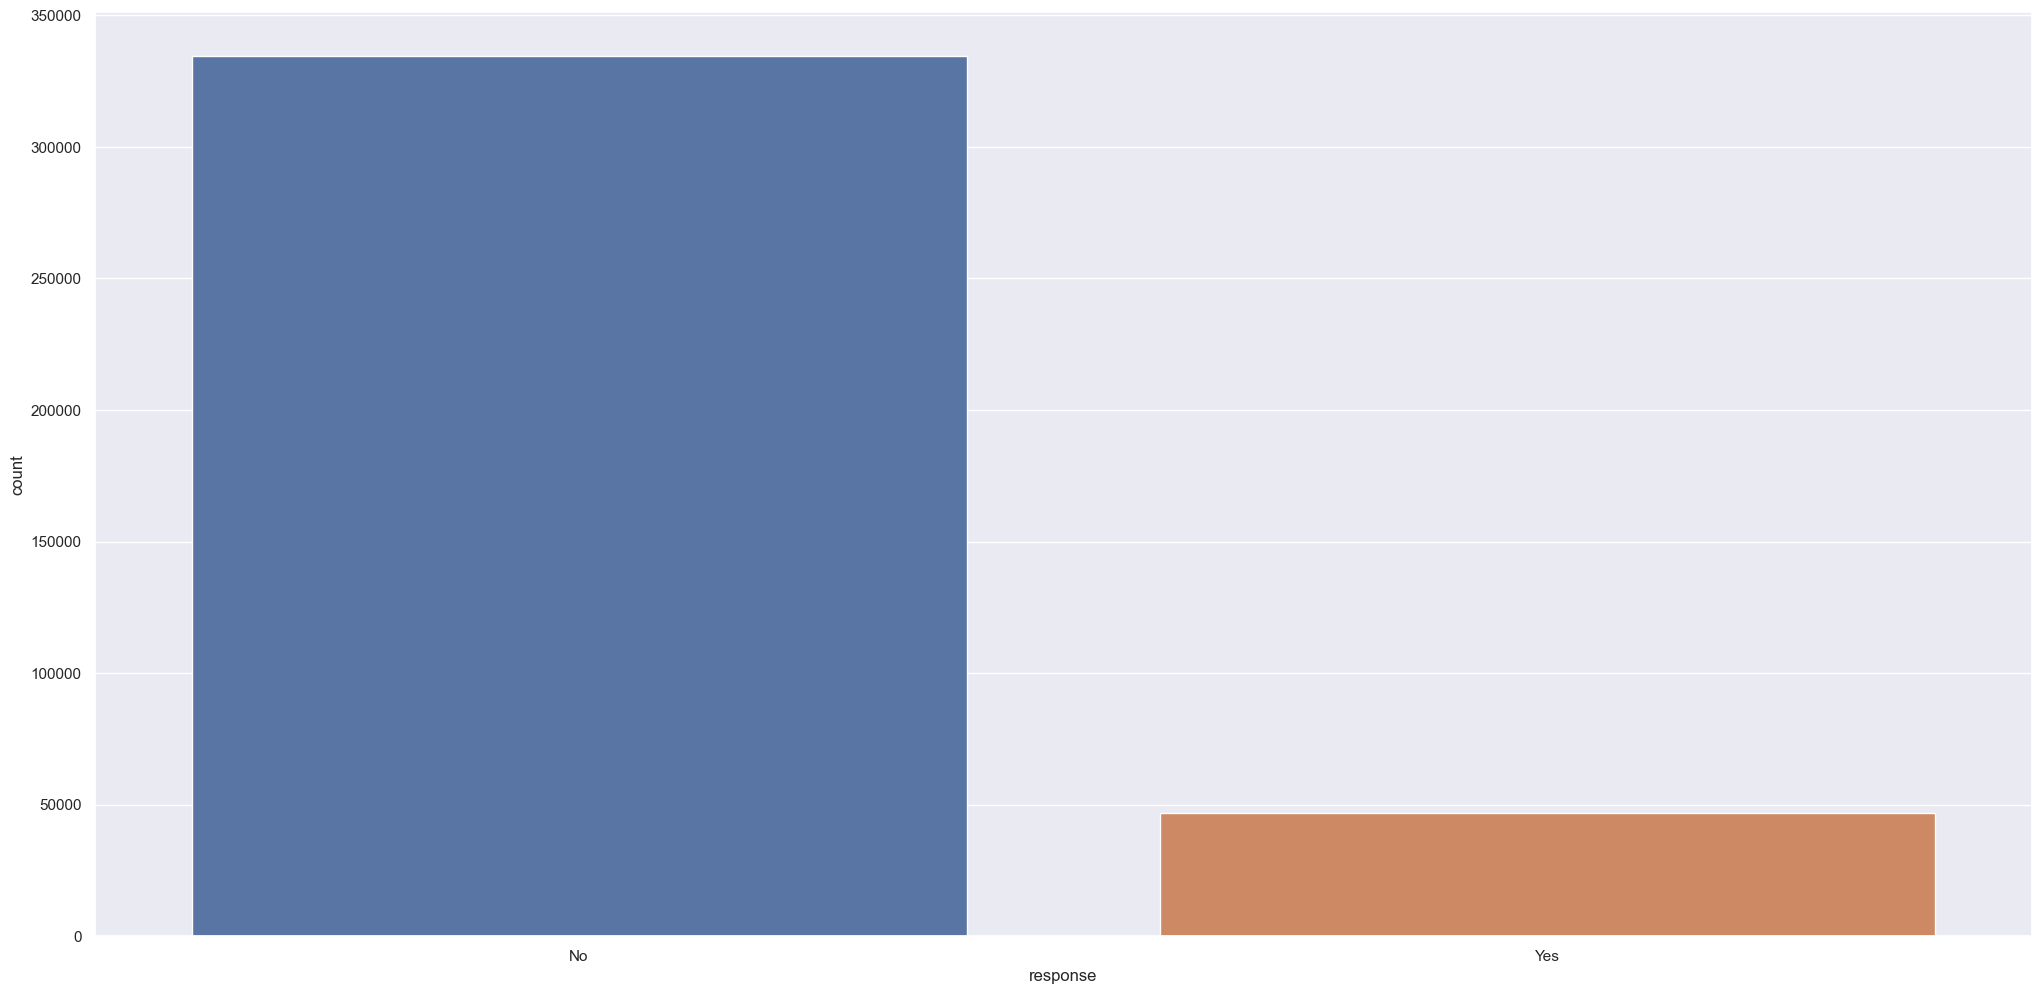

In [15]:
# counts each class for the target var
_ = sns.countplot(x=df2['response'])

# sets plot features
plt.xticks(ticks=[0,1], labels=['No','Yes'])

# displays the plot
plt.show()

# BALANCEAR DADOS!!!!!!

### Attributes Analysis

In [16]:
# Split Numerical/Categorical Atributes

num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes( include=['object'])

# Criar: df_eda: 
# num_attributes - int, float
# cat_attributes = driving_license, previously_insured, vehicle_damage, gender

In [35]:
df1.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_year
0,1,Male,44,1,28,0,> 2 Years,1,40454,26,217,1,2
1,2,Male,76,1,3,0,1-2 Year,0,33536,26,183,0,1


In [34]:
df1['vehicle_age_year'].unique()

array([2, 1, 0], dtype=int64)

In [17]:
# Cental Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( np.min )).T
d3 = pd.DataFrame(num_attributes.apply( np.max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T


# Concatenate
table_m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
table_m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

table_m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
9,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [18]:
cat_attributes = df2.select_dtypes( include=['object']).sample(10)
cat_attributes

,gender,vehicle_age
185313,Female,< 1 Year
203477,Female,< 1 Year
282918,Female,1-2 Year
266047,Male,< 1 Year
299500,Male,1-2 Year
218754,Female,1-2 Year
227025,Male,1-2 Year
213946,Female,< 1 Year
308485,Female,1-2 Year
194693,Female,< 1 Year


## EDA

### Univariate Anaysis

#### Numerial Variable

In [20]:
# #Age analysis
# plt.subplot(2,1,1)
# sns.histplot(x='age',
#              data=df2[df2['satisfaction'] == 'Satisfied'],
#              hue='satisfaction');

# plt.subplot(2,1,2)
# sns.histplot(x='age',
#              data=df2[df2['satisfaction'] == 'Neutral or Dissatisfaction'],
#              hue='satisfaction');

#### Categorical Variable

In [21]:
# # Categorical analysis

# plt.subplot(3,3,1)
# sns.countplot(
#     x='customer_type',
#     hue=('satisfaction'),
#     data=df2,
# );

# plt.subplot(3,3,2)
# sns.countplot(
#     x='type_of_purchase',
#     hue=('satisfaction'),
#     data=df2,
# );

# plt.subplot(3,3,3)
# sns.countplot(
#      x='store_size',
#     hue=('satisfaction'),
#     data=df2,
# );

### Bivariate Analysis - later

#### Hyphoteses List



- Clientes que já pagaram seguro previamente comprariam novo seguro
- Mulheres compram mais seguros do que homem
- Clientes que vivem em regiões mais perigosas compram mais
- Clientes com mais idade compram mais
- Clientes que não possuem CHN não compram
- Carros mais danificados precisam de seguro
- Carros mais velhos precisam de seguro
- Carros que já possuem seguros não precisam de novo seguro

#### Mental Map

### Multivariate Analysis

In [22]:
# nominal.associations(df3.drop('id',axis = 1));

# Data Preparation

In [24]:
# Df4
df4 = df2.copy()
df4test = df2test.copy()

### Data Filtering

In [30]:
# Drop!! vehicle_age

df6.drop(['vehicle_age'], axis=1, inplace=True)
df6test.drop(['vehicle_age'], axis=1, inplace=True)

### Data Split

In [ ]:
# # Separando as variáveis explicativas da variável resposta.

# x = df6.drop('response', axis = 1)
# y = df6['response']


# # Treino(100%) -> treino(80%) e validação(20%)
# x_train, x_validation, y_train, y_validation = ms.train_test_split(x, y, test_size=0.20) 

# # Criar o objeto RandomOverSampler - Ajustando variável 'response' desbalanceada
# over_sampler = RandomOverSampler(random_state=42)

# # Aplicar o oversampling no conjunto de treinamento
# x_train_balanced, y_train_balanced = over_sampler.fit_resample(x_train, y_train)

# df_train = pd.concat([x_train, y_train], axis=1) # juntar as variaveis preditoras com a variavel alvo

# # Teste =  df6test


In [ ]:
print(df6['response'].value_counts())

0    334399
1     46710
Name: response, dtype: int64


In [ ]:
# Separando as variáveis explicativas da variável resposta.

x = df6.drop('response', axis = 1)
y = df6['response']

# # Criar o objeto RandomOverSampler - Ajustando variável 'response' desbalanceada
# over_sampler = RandomOverSampler(random_state=42)

# # Aplicar o oversampling no conjunto de treinamento
# x_train_balanced, y_train_balanced = over_sampler.fit_resample(x, y)

df_train = pd.concat([x, y], axis=1) # juntar as variaveis preditoras com a variavel alvo

# Teste =  df6test

### Preparation

In [26]:
def data_preparation(data):
    rs = RobustScaler()
    mms = MinMaxScaler()
    le = LabelEncoder()

    ## Rescaling

    # MinMax scaler = sem outlier
    # age, region_code, policy_sales_channel, vintage, response(?), vehicle_age_year
    data['age'] = mms.fit_transform(data[['age']].values)
    data['region_code'] = mms.fit_transform(data[['region_code']].values)
    data['policy_sales_channel'] = mms.fit_transform(data[['policy_sales_channel']].values)
    data['vintage'] = mms.fit_transform(data[['vintage']].values)
    data['vehicle_age_year'] = mms.fit_transform(data[['vehicle_age_year']].values)

    # RobustScaler = com outlier
    # annual_premium
    data['annual_premium'] = rs.fit_transform(data[['annual_premium']].values)

    ## Transformation

    # LaberEncoder - Categorical
    data['gender'] = le.fit_transform(data[['gender']].values.ravel())

    preparation = data
    return preparation

In [27]:
df5 = data_preparation(df4)
df5test = data_preparation(df4test)

In [28]:
df5.head(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_year
0,1,1,0.369231,1,0.538462,0,> 2 Years,1,0.585862,0.154321,0.716263,1,1.0
1,2,1,0.861538,1,0.057692,0,1-2 Year,0,0.124508,0.154321,0.598616,0,0.5
2,3,1,0.415385,1,0.538462,0,> 2 Years,1,0.441814,0.154321,0.058824,1,1.0
3,4,1,0.015385,1,0.211538,1,< 1 Year,0,-0.203401,0.932099,0.667820,0,0.0
4,5,0,0.138462,1,0.788462,1,< 1 Year,0,-0.278293,0.932099,0.100346,0,0.0


# Feature Selection

In [29]:
df6 = df5.copy()
df6test = df5test.copy()

In [ ]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
X_df6_n = df6.drop(['response'], axis=1)
y_df6_n = df6['response']

forest.fit(X_df6_n, y_df6_n)

# Time: 46s


In [ ]:
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# print the feature ranking

print('Feature ranking')

df = pd.DataFrame()

for i, j in zip(X_df6_n, forest.feature_importances_):
    
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Feature ranking
                feature  importance
0                    id    0.193349
0               vintage    0.187256
0        annual_premium    0.163926
0                   age    0.137335
0           region_code    0.094442
0        vehicle_damage    0.076180
0  policy_sales_channel    0.067525
0    previously_insured    0.054571
0      vehicle_age_year    0.019001
0                gender    0.005949
0       driving_license    0.000465


In [ ]:
# Features choose

#cols_selected =  ['id', 'vintage', 'annual_premium', 'age', 'region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age_year', ]

# Machine Learning

In [ ]:
# Validação cruzada Leave One Out
kf = StratifiedKFold(n_splits = 10)

In [ ]:
# Verificando a performance da Regressão Logística

lista_de_medidas = ['precision']

modelo = LogisticRegression()
accs_vc = cross_validate(modelo, x_train_balanced, y_train_balanced, cv = kf, scoring = lista_de_medidas)

In [ ]:
print(accs_vc['test_precision'].mean())

0.3187541462120207


In [ ]:
# verificando a performance da Regressão Logística
def MachineLearning(dataset):

    lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']

    nome_das_medidas = ['acurácia', 'sensibilidade', 'vpp', 'eficiência', 'f1-score']

    lista_de_modelos = [LogisticRegression(),
                        DecisionTreeClassifier(max_depth = 3),
                        DecisionTreeClassifier(max_depth = 5),
                        DecisionTreeClassifier(max_depth = 7),
                        KNeighborsClassifier(n_neighbors = 5),
                        KNeighborsClassifier(n_neighbors = 15),
                        KNeighborsClassifier(n_neighbors = 25),
                        BaggingClassifier(),
                        RandomForestClassifier(n_estimators=300, max_depth = 3, max_features = 3),
                        RandomForestClassifier(n_estimators=300, max_depth = 3, max_features = 4),
                        RandomForestClassifier(n_estimators=300, max_depth = 6, max_features = 3),
                        RandomForestClassifier(n_estimators=300, max_depth = 6, max_features = 4)]

    nome_dos_modelos = ['Regressão Logística',
                        'Árvore (prof = 3)',
                        'Árvore (prof = 5)',
                        'Árvore (prof = 7)',
                        '5-NN',
                        '15-NN',
                        '25-NN',
                        'Bagging',
                        'Random Forest (prof = 3, mf = 3)',
                        'Random Forest (prof = 3, mf = 4)',
                        'Random Forest (prof = 6, mf = 3)',
                        'Random Forest (prof = 6, mf = 4)']

    resultados0 = {}

    for i in range(len(lista_de_modelos)):
        print('Rodando modelo: ' + nome_dos_modelos[i])
        accs_vc = cross_validate(lista_de_modelos[i], x_train_balanced, y_train_balanced, cv = kf, scoring = lista_de_medidas)

        acc = accs_vc['test_accuracy'].mean()
        sen = accs_vc['test_recall'].mean()
        vpp = accs_vc['test_precision'].mean()
        bac = accs_vc['test_balanced_accuracy'].mean()
        f1s = accs_vc['test_f1'].mean()

        resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, f1s, bac]
    
    resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

    return resultados

In [ ]:
MachineLearning(df_train)


### Best models compare

In [ ]:
# modelo Bagging
bg = BaggingClassifier()

x_train = df_train.drop('response', axis=1)
y_train = df_train['response']

# Fazendo a validação cruzada para obter as previsões do modelo
y_pred_cv = cross_val_predict(bg, x_train, y_train, cv=5)

# Calculando as métricas de avaliação com base nas previsões da validação cruzada
accuracy = accuracy_score(y_train, y_pred_cv)
recall = recall_score(y_train, y_pred_cv)
precision = precision_score(y_train, y_pred_cv)
balanced_accuracy = balanced_accuracy_score(y_train, y_pred_cv)
f1 = f1_score(y_train, y_pred_cv)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.8274614349175695
Recall: 0.248747591522158
Precision: 0.2747847885725097
Balanced Accuracy: 0.5785228811351382
F1 Score: 0.26111872710519807


# Fine Tuning

### Final Result

### Cross-Validation

# Business Performance